# Importações


In [10]:
import torch

# Camadas e funções de redes neurais (Linear, Conv2d, ReLU)
import torch.nn as nn
import torch.nn.functional as F

# Otimizador que atualizam os pesos SGD(descida do gradiente) Adam(mais avançado)
# Os otimizadores da rede ajustam os pesos após cada erro
import torch.optim as optim

# Ferramentas para visão computacional
import torchvision

# Transformações aplicadas nas imagens, como: Girar, normalizar, inverter
import torchvision.transforms as transforms

# Fica os datasets
import torchvision.datasets as datasets

from torchvision.datasets import ImageFolder

# Ferramentas para manipular os dados
# DataLoader: Entrega os dados em mini-batches
# random_split: divide em treino/teste de forma aleatória
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt

import os

import random

import shutil

## Inicializando a GPU

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


# Organizando as pastas

Quero organizar assim <br>

dataset/ <br>
├── treino/ <br>
│   ├── gato/ <br>
│   └── cachorro/ <br>
├── teste/ <br>
│   ├── gato/ <br> 
│   └── cachorro/ <br>


In [12]:
# Configurações
caminho_gatos = '../../../../../../Downloads/archive/PetImages/Cat'
caminho_cachorros = '../../../../../../Downloads/archive/PetImages/Dog'
destino_base = '../../../../../../Downloads/archive/dataset'
proporcao_treino = 0.8

# Cria pastas destino
for modo in ['treino', 'teste']:
    for classe in ['gato', 'cachorro']:
        path = os.path.join(destino_base, modo, classe)
        os.makedirs(path, exist_ok=True)

# Função para separar e copiar arquivos
def copiar_arquivos(origem, classe):
    arquivos = os.listdir(origem)
    random.shuffle(arquivos)
    for arquivo in arquivos:
        caminho_origem = os.path.join(origem, arquivo)
        if random.random() < proporcao_treino:
            destino = os.path.join(destino_base, 'treino', classe, arquivo)
        else:
            destino = os.path.join(destino_base, 'teste', classe, arquivo)
        shutil.copy(caminho_origem, destino)

# Executa para gatos e cachorros
copiar_arquivos(caminho_gatos, 'gato')
copiar_arquivos(caminho_cachorros, 'cachorro')

# Carregando os dados com ImageFolder e aplicando Transformações

In [13]:
transformacoes = transforms.Compose([
  transforms.Resize((128, 128)), # Redimensiona todas as imagens para 128x128
  transforms.ToTensor(), # Converte imagem para tensor (0.0a 1.0)
  transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normaliza para -1 a 1
])

## Carregar com ImageFolder

In [14]:
from PIL import Image

def verificar_imagem(path):
    try:
        Image.open(path).verify()
        return True
    except:
        return False

In [15]:
# Caminhos das pastas
caminho_treino = '../../../../../../Downloads/archive/dataset/treino'
caminho_teste = '../../../../../../Downloads/archive/dataset/teste'

# Carrega os datasets
dataset_treino = ImageFolder(root=caminho_treino, transform=transformacoes, is_valid_file=verificar_imagem)
dataset_teste = ImageFolder(root=caminho_teste, transform=transformacoes, is_valid_file=verificar_imagem)

# Cria os DataLoaders
loader_treino = DataLoader(dataset_treino, batch_size=32, shuffle=True)
loader_teste = DataLoader(dataset_teste, batch_size=32, shuffle=False)

## Verificando se está carregando certo

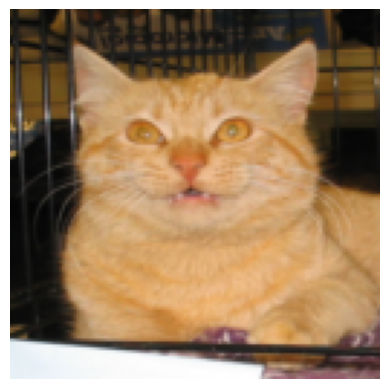

Classe: gato


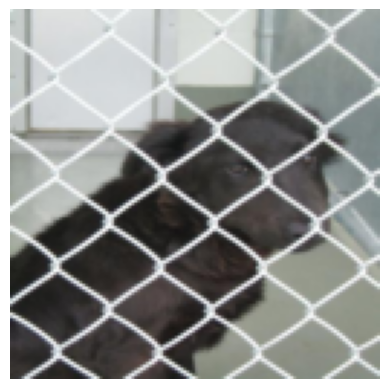

Classe: cachorro


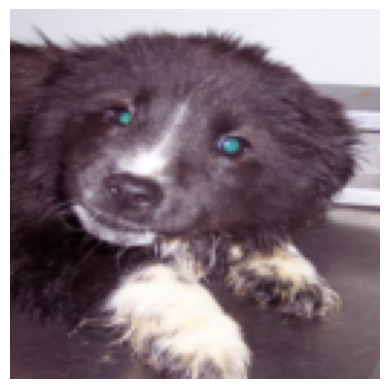

Classe: cachorro


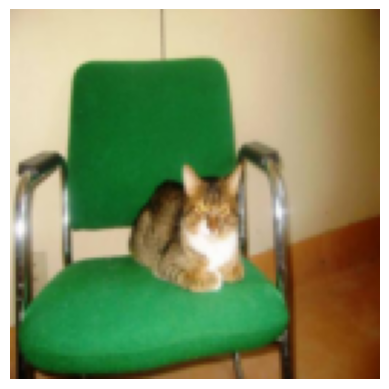

Classe: gato


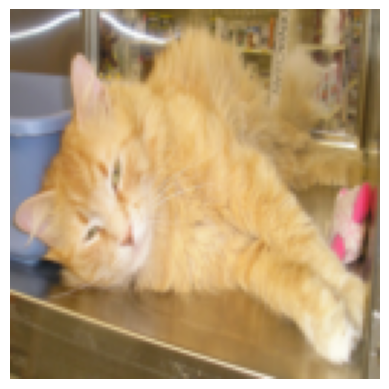

Classe: gato


In [16]:
# Função para desnormalizar imagem e mostrar
def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))  # CxHxW → HxWxC
    img = img * 0.5 + 0.5  # desfaz a normalização
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Pega um mini-batch do loader
dados = next(iter(loader_treino))
imagens, rotulos = dados

# Mostra as primeiras 4 imagens com rótulo
for i in range(5):
    imshow(imagens[i])
    print("Classe:", dataset_treino.classes[rotulos[i]])

# Construindo a Rede Neural (CNN)

In [17]:
class CNN(nn.Module):
  def __init__(self):
      super(CNN, self).__init__()

      # Camadas convolucionais
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
      self.pool = nn.MaxPool2d(2,2)

      self.conv2 = nn.Conv2d(16, 32, 3)

      # Camadas totalmente conectadas
      self.fc1 = nn.Linear(32 * 30 * 30, 64)
      self.fc2 = nn.Linear(64, 2) # Saída com 2 neurônios: [gato, cachorro]

  def forward(self, x):
     x = self.pool(F.relu(self.conv1(x)))
     x = self.pool(F.relu(self.conv2(x)))
     x = x.view(-1, 32 * 30 * 30)
     x = F.relu(self.fc1(x))
     x = self.fc2(x)
     return x
  
model = CNN().to(device) 
print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=28800, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


In [18]:
sample = next(iter(loader_treino))[0][0].unsqueeze(0).to(device)  # 1 imagem
saida = model(sample)
print("Saída bruta:", saida)

Saída bruta: tensor([[0.0567, 0.0387]], device='cuda:0', grad_fn=<AddmmBackward0>)


# Configurar a função de perda, otimizador e loop de treinamento

In [19]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [20]:
num_epochs = 5

for epoch in range(num_epochs):
  model.train()
  total_loss = 0
  corretos =0
  total = 0

  for imagens, rotulos in loader_treino:
    imagens, rotulos = imagens.to(device), rotulos.to(device)

    # Zera o gradientes antigos
    optimizer.zero_grad()

    # Passa as imagens pelo modelo
    saida = model(imagens)

    # Calcula o erro (perda)
    loss = criterion(saida, rotulos)

    # Calcula o gradiente
    loss.backward()

    # Atualiza os pesos do modelo
    optimizer.step()

    # Acumula perda e acertos para estatísticas
    total_loss += loss.item()
    _, predicoes = torch.max(saida, 1)
    corretos += (predicoes == rotulos).sum().item()
    total += rotulos.size(0)

  acc  = 100 * corretos / total
  media_loss = total_loss / len(loader_treino)
  print(f"Épocas {epoch+1}/{num_epochs} loss: {media_loss:.4f} - acurácia: {acc:.2f}%")

Épocas 1/5 loss: 0.5625 - acurácia: 70.18%
Épocas 2/5 loss: 0.4456 - acurácia: 79.16%
Épocas 3/5 loss: 0.3662 - acurácia: 83.69%
Épocas 4/5 loss: 0.2866 - acurácia: 87.58%
Épocas 5/5 loss: 0.1922 - acurácia: 92.35%


In [21]:
model.eval()
corretos = 0
total = 0

with torch.no_grad():
    for imagens, rotulos in loader_teste:
        imagens, rotulos = imagens.to(device), rotulos.to(device)
        saida = model(imagens)
        _, predicoes = torch.max(saida, 1)
        corretos += (predicoes == rotulos).sum().item()
        total += rotulos.size(0)

acc_teste = 100 * corretos / total
print(f"📊 Acurácia no conjunto de TESTE: {acc_teste:.2f}%")


📊 Acurácia no conjunto de TESTE: 97.32%


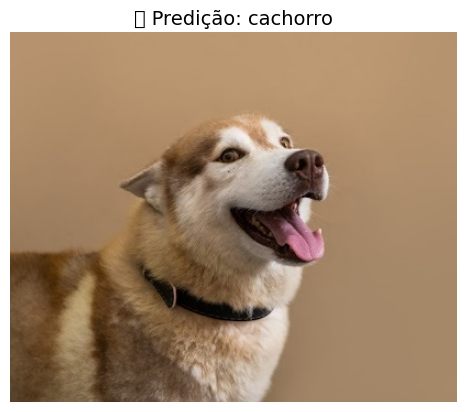

In [22]:
from PIL import Image
import matplotlib.pyplot as plt

# Caminho da imagem nova
caminho_imagem = "meu_cachorro.jpg"  # substitua pelo nome correto

# Carrega e transforma a imagem para o modelo
imagem = Image.open(caminho_imagem).convert("RGB")
imagem_tensor = transformacoes(imagem).unsqueeze(0).to(device)

# Faz predição
model.eval()
with torch.no_grad():
    saida = model(imagem_tensor)
    _, pred = torch.max(saida, 1)

# Obtém o nome da classe
classe_predita = dataset_treino.classes[pred.item()]

# Mostra a imagem original com o título sendo a predição
plt.imshow(imagem)
plt.title(f"🔎 Predição: {classe_predita}", fontsize=14)
plt.axis('off')
plt.show()
